In [49]:
from rasterio.plot import show
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
df = pd.read_csv('/home/egodin/Documents/projects/mycoCarte/data/interim/model/testData.csv', index_col= 0)

# Remove bias features 
df = df.drop(['populationDensity',
                    'distanceToUrban',
                    'distanceRo',
                    'urbanArea',
                    'airesProtegees'
                    ], axis = 1)
print(df.head())

df = df.set_index('FID')


# Remove skewed cat feature 
df = df.drop(['etagement'], axis = 1)

# Remove geo features,
df = df.drop(['block_id',
                    'regionCode'
                    ], axis = 1)
#print(df.head())

     FID  block_id ty_couv_et  cl_dens  cl_haut  cl_age_et etagement  cl_pent  \
264  264         2          F      3.0      7.0  55.000000        MO      2.0   
265  265         2          R      4.0      7.0  82.857143        MO      1.0   
266  266         2          R      3.0      7.0  87.727273        MO      3.0   
267  267         2          R      3.0      7.0  95.000000        MO      3.0   
268  268         2         MF      3.0      6.0  99.000000        MO      4.0   

       hauteur                 dep_sur  ...   bioclim_04  bioclim_05  \
264  28.000000  Depot fluvio-glaciaire  ...  1150.548950   25.299999   
265  28.285714  Depot fluvio-glaciaire  ...  1150.548950   25.299999   
266  27.454545         Depot Glaciaire  ...  1154.230225   25.100000   
267  27.166667         Depot Glaciaire  ...  1154.230225   25.100000   
268  24.600000         Depot Glaciaire  ...  1156.614014   25.100000   

     bioclim_08  bioclim_09  bioclim_10  bioclim_12  bioclim_15  bioclim_16  \
2

                     cl_dens   cl_haut  cl_age_et   cl_pent   hauteur  \
cl_dens             1.000000  0.123685  -0.018578  0.111646  0.148789   
cl_haut             0.123685  1.000000   0.352823  0.054647  0.823446   
cl_age_et          -0.018578  0.352823   1.000000 -0.051877  0.408504   
cl_pent             0.111646  0.054647  -0.051877  1.000000  0.057394   
hauteur             0.148789  0.823446   0.408504  0.057394  1.000000   
cl_drai            -0.070013 -0.067914   0.002315 -0.518907 -0.082337   
tree_diver          0.092585  0.326368   0.081638 -0.055119  0.336268   
tree_shannon_index  0.101354  0.489526   0.329497  0.021369  0.576851   
bioclim_01          0.014104  0.435828   0.262348 -0.357202  0.556972   
bioclim_02          0.031857  0.343334   0.025381  0.049521  0.417654   
bioclim_03          0.057227  0.299177   0.033808  0.040599  0.356267   
bioclim_04         -0.022755  0.254510   0.021283 -0.005528  0.323998   
bioclim_05          0.006110  0.505514   0.234459 -

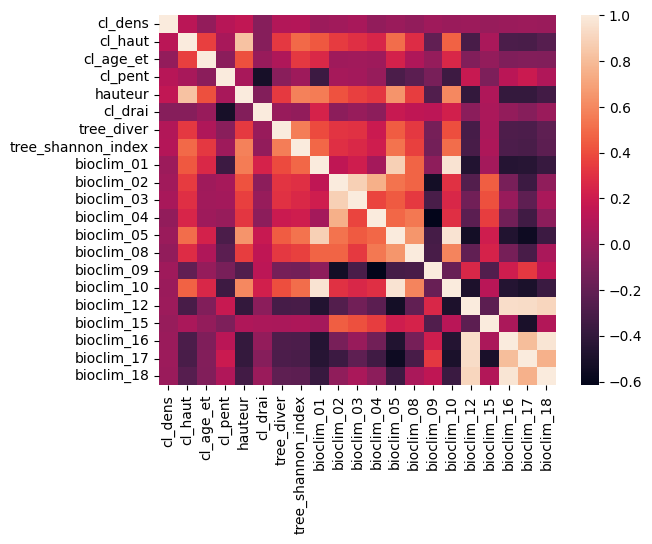

In [51]:
corr = df.corr(numeric_only= True)
sns.heatmap(corr)
print(corr)

In [52]:
# Remove colinear features 

df = df.drop(['hauteur',
              'bioclim_01',
              'bioclim_05'
              ], axis = 1)

In [53]:
#Removes Nans

print(df.shape)
df = df.dropna()
print(df.shape)

print(df.isna().sum())

(608492, 20)
(608492, 20)
ty_couv_et            0
cl_dens               0
cl_haut               0
cl_age_et             0
cl_pent               0
dep_sur               0
cl_drai               0
tree_diver            0
tree_shannon_index    0
bioclim_02            0
bioclim_03            0
bioclim_04            0
bioclim_08            0
bioclim_09            0
bioclim_10            0
bioclim_12            0
bioclim_15            0
bioclim_16            0
bioclim_17            0
bioclim_18            0
dtype: int64


In [54]:
from mycoCarte import Utils

df = Utils.encodeBioclim(df)
print(df.columns)

Index(['ty_couv_et', 'cl_dens', 'cl_haut', 'cl_age_et', 'cl_pent', 'dep_sur',
       'cl_drai', 'tree_diver', 'tree_shannon_index', 'Mean Diurnal Range',
       'Isothermality', 'Temp Seasonality', 'Mean Temp of Wettest Quarter',
       'Mean Temp of Driest Quarter', 'Mean Temp of Warmest Quarter',
       'Annual Precip', 'Precip Seasonality', 'Precip of Wettest Quarter',
       'Precip of Driest Quarter', 'Precip of Warmest Quarter'],
      dtype='object')


In [55]:
# Split features
feature_names = []
categorical_feats = []
numeric_feats = []

for col in df.columns:
    feature_names.append(col)
    if col == 'FID':
        pass
    
    if df[col].dtype == 'object':
        categorical_feats.append(col) 
    else:
        numeric_feats.append(col)

print(feature_names)

index = df.index

df_categorical = df[categorical_feats]
df_numerical = df[numeric_feats]

['ty_couv_et', 'cl_dens', 'cl_haut', 'cl_age_et', 'cl_pent', 'dep_sur', 'cl_drai', 'tree_diver', 'tree_shannon_index', 'Mean Diurnal Range', 'Isothermality', 'Temp Seasonality', 'Mean Temp of Wettest Quarter', 'Mean Temp of Driest Quarter', 'Mean Temp of Warmest Quarter', 'Annual Precip', 'Precip Seasonality', 'Precip of Wettest Quarter', 'Precip of Driest Quarter', 'Precip of Warmest Quarter']


In [56]:
#Caterogical 
# One Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df_categorical)
df_categorical = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_feats), index= index)
print("After OneHotEncoding (if applied):")
#print(df_categorical.head())

categorical_feats = encoder.get_feature_names_out(categorical_feats)
categorical_feats = categorical_feats.tolist()
print(categorical_feats)
print(type(categorical_feats))

After OneHotEncoding (if applied):
['ty_couv_et_F', 'ty_couv_et_MF', 'ty_couv_et_MM', 'ty_couv_et_MR', 'ty_couv_et_R', 'dep_sur_Autre depot', 'dep_sur_Depot Glaciaire', 'dep_sur_Depot de pente', 'dep_sur_Depot eolien', 'dep_sur_Depot fluviatile', 'dep_sur_Depot fluvio-glaciaire', 'dep_sur_Depot lacustre', 'dep_sur_Depot litoral marin', 'dep_sur_Depot marin', 'dep_sur_Depot organique', 'dep_sur_Rocheux']
<class 'list'>


In [57]:
#Numerical 
# #Feature Scaling

df_numerical = df[numeric_feats]
scaler = StandardScaler() # Or MinMaxScaler()
scaled_features = scaler.fit_transform(df_numerical)
print("\nScaled data (first 5 rows):")
df_numerical = pd.DataFrame(scaled_features, columns=numeric_feats, index= index)
print(df_numerical.head())


Scaled data (first 5 rows):
      cl_dens   cl_haut  cl_age_et   cl_pent   cl_drai  tree_diver  \
FID                                                                  
264 -0.382465  1.636363  -0.078661 -0.507587 -1.317848   -1.710175   
265  1.102218  1.636363   1.589858 -1.243776 -1.317848   -1.431556   
266 -0.382465  1.636363   1.881558  0.228601 -1.317848    0.797393   
267 -0.382465  1.636363   2.317162  0.228601 -1.317848    1.354630   
268 -0.382465  0.677964   2.556744  0.964790  0.117081    1.076011   

     tree_shannon_index  Mean Diurnal Range  Isothermality  Temp Seasonality  \
FID                                                                            
264           -1.343686            0.853705       0.873846          0.337683   
265           -1.083103            0.853705       0.873846          0.337683   
266           -0.128064            0.939366       0.973609          0.422878   
267            0.208568            0.939366       0.973609          0.422878   


In [58]:
#PCA (Principal Component Analysis):

# Decide on the number of components (e.g., to explain 95% of variance)
pca = PCA(n_components=0.95) 

# Or specify a fixed number: pca = PCA(n_components=3)
features_pca = pca.fit_transform(df_numerical)

print(f"\nShape after PCA: {features_pca.shape}")
# 5. Get the explained variance
explained_variance = pca.explained_variance_ratio_
print("\n--- Explained Variance by Each Component ---")
for i, variance in enumerate(explained_variance):
    print(f"PC-{i+1}: {variance:.3f} ({variance*100:.1f}%)")
print(f"Total Explained Variance: {np.sum(explained_variance):.3f} ({np.sum(explained_variance)*100:.1f}%)")
# For subsequent steps, decide whether to use 'scaled_features' or 'features_pca'




Shape after PCA: (608492, 12)

--- Explained Variance by Each Component ---
PC-1: 0.306 (30.6%)
PC-2: 0.158 (15.8%)
PC-3: 0.100 (10.0%)
PC-4: 0.096 (9.6%)
PC-5: 0.059 (5.9%)
PC-6: 0.053 (5.3%)
PC-7: 0.048 (4.8%)
PC-8: 0.040 (4.0%)
PC-9: 0.032 (3.2%)
PC-10: 0.028 (2.8%)
PC-11: 0.024 (2.4%)
PC-12: 0.021 (2.1%)
Total Explained Variance: 0.965 (96.5%)


--- PCA Component Loadings ---


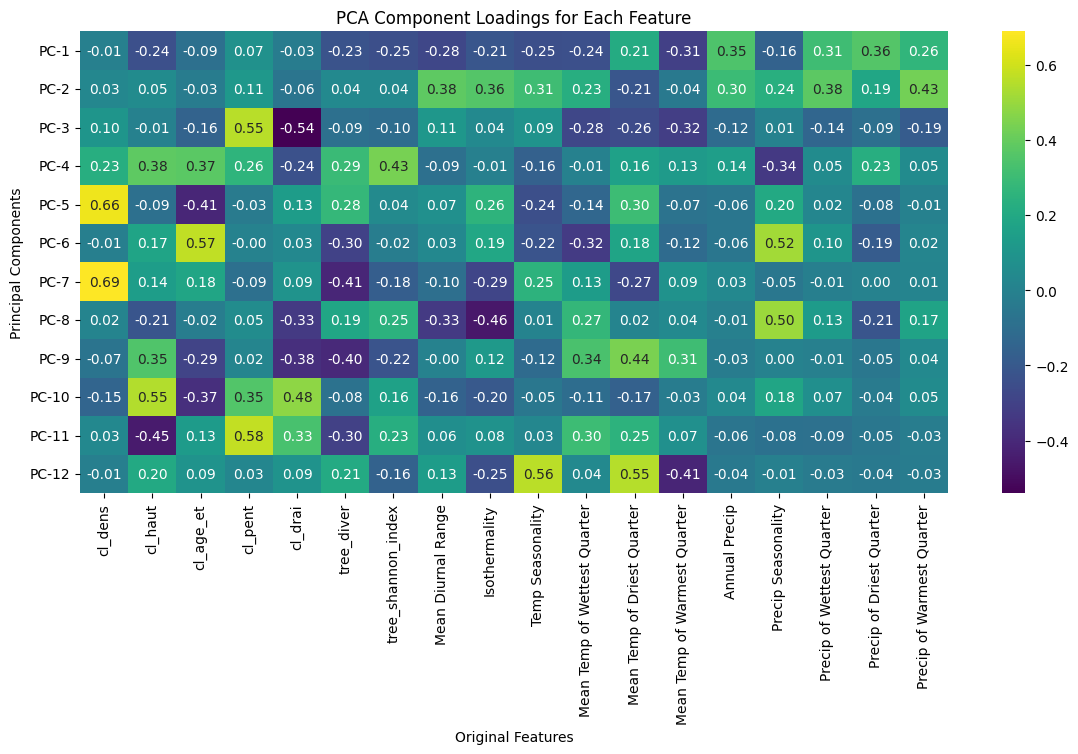

In [59]:
# The components are stored in the pca.components_ attribute
# It's best to view them in a DataFrame for clarity
components_df = pd.DataFrame(
    pca.components_,
    columns=numeric_feats,
    index=[f'PC-{i+1}' for i in range(pca.n_components_)]
)

print("--- PCA Component Loadings ---")
# 4. Visualize the Components for easier interpretation
plt.figure(figsize=(14, 6))
sns.heatmap(components_df, cmap="viridis", annot=True, fmt='.2f')
plt.title('PCA Component Loadings for Each Feature')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

In [60]:
df_pca = pd.DataFrame(features_pca, index= index)
pca_feats = []
for id, col in enumerate(df_pca.columns):
    id = id +1
    df_pca.rename(columns={col : f'pca_{id}'}, inplace= True)
    pca_feats.append(f'pca_{id}')
#print(df_pca)

In [61]:
# Merge transformed features
df = pd.concat([df_pca, df_categorical], axis=1)

#df = pd.concat([df_numerical, df_categorical], axis=1)

print(df.head())


        pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
FID                                                                         
264 -2.771514 -1.705006  1.151599 -1.317294 -0.299931  1.334345  0.289215   
265 -3.126075 -1.773630  0.580218 -0.348690  0.112502  2.185702  1.522167   
266 -3.686671 -1.329275  0.929147  0.863353 -0.389588  1.671369 -0.669262   
267 -3.936711 -1.308938  0.773717  1.333758 -0.397670  1.748346 -0.877180   
268 -3.650307 -1.283770  0.380330  0.957086 -0.327264  1.778868 -0.837515   

        pca_8     pca_9    pca_10  ...  dep_sur_Depot Glaciaire  \
FID                                ...                            
264 -0.952214  3.174216 -0.626323  ...                      0.0   
265 -0.890021  2.399690 -1.707272  ...                      0.0   
266 -0.291601  1.265133 -1.114317  ...                      1.0   
267 -0.115085  0.840673 -1.266013  ...                      1.0   
268 -0.483311 -0.032025 -0.923126  ...                    

In [62]:
def kTests():
    k_range = range(5, 20) # Example range for K
    inertia_values = []
    silhouette_scores = []
    davies_bouldin_scores = []

    for ix, k_test in enumerate(k_range):
        print(ix)
        # K-Means
        kmeans_test = KMeans(n_clusters=k_test, random_state=42, n_init='auto')
        kmeans_test.fit_predict(df)
        inertia_values.append(kmeans_test.inertia_)
        
        # Silhouette Score (can be computationally expensive for large datasets)
        # For large datasets, you might use a sample:
        from sklearn.utils import resample
        sample_indices = list(resample(np.arange(df.shape[0]), n_samples=min(10000, df.shape[0]), random_state=42))
        sample_data = df.iloc[sample_indices]
        sample_labels = kmeans_test.predict(sample_data) # or predict on full and subset labels
        if len(np.unique(sample_labels)) > 1: # Silhouette needs at least 2 labels
            silhouette_scores.append(silhouette_score(sample_data, sample_labels))
            davies_bouldin_scores.append(davies_bouldin_score(sample_data, sample_labels))

        else:
            silhouette_scores.append(-1) # Invalid
            davies_bouldin_scores.append(float('inf'))
        labels_test = kmeans_test.labels_


    # Plotting the Elbow Method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(k_range, inertia_values, marker='o')
    plt.title('Elbow Method for K-Means')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')

    # Plotting Silhouette Scores
    plt.subplot(1, 3, 2)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Average Silhouette Score')

    # Plotting Davies-Bouldin Index
    plt.subplot(1, 3, 3)
    plt.plot(k_range, davies_bouldin_scores, marker='o')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

#kTests()

In [63]:
# --- Choose your K based on these plots and domain knowledge ---
# Example: Let's say K=4 seems optimal from the plots
optimal_k = 10
print(f"\nSelected optimal K: {optimal_k}")


Selected optimal K: 10


In [64]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(df)
algorithm_name = "KMeans"
df_with_clusters = df.copy() # Use the version before scaling for interpretability
df_with_clusters['cluster'] = cluster_labels
print(df_with_clusters.head())


        pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
FID                                                                         
264 -2.771514 -1.705006  1.151599 -1.317294 -0.299931  1.334345  0.289215   
265 -3.126075 -1.773630  0.580218 -0.348690  0.112502  2.185702  1.522167   
266 -3.686671 -1.329275  0.929147  0.863353 -0.389588  1.671369 -0.669262   
267 -3.936711 -1.308938  0.773717  1.333758 -0.397670  1.748346 -0.877180   
268 -3.650307 -1.283770  0.380330  0.957086 -0.327264  1.778868 -0.837515   

        pca_8     pca_9    pca_10  ...  dep_sur_Depot de pente  \
FID                                ...                           
264 -0.952214  3.174216 -0.626323  ...                     0.0   
265 -0.890021  2.399690 -1.707272  ...                     0.0   
266 -0.291601  1.265133 -1.114317  ...                     0.0   
267 -0.115085  0.840673 -1.266013  ...                     0.0   
268 -0.483311 -0.032025 -0.923126  ...                     0.0  

In [65]:
df_out = df_with_clusters['cluster']
df_out.to_csv('/home/egodin/Documents/projects/mycoCarte/data/output/envClustering.csv')

In [66]:
pca_feats_cluster = pca_feats
if 'cluster' not in pca_feats_cluster:
    pca_feats_cluster.append('cluster')
    
print(pca_feats_cluster)

numerical_df_clustered = df_with_clusters[pca_feats_cluster]

numerical_cluster_profiles = numerical_df_clustered.groupby('cluster')[pca_feats].agg(['mean', 'median'])\



#print(numerical_cluster_profiles)

['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'cluster']


In [67]:
categorical_feats_cluster = categorical_feats
if 'cluster' not in categorical_feats_cluster:
    categorical_feats_cluster.append('cluster')
print(categorical_feats_cluster)

categorical_df_clustered = df_with_clusters[categorical_feats_cluster]
categorical_cluster_profile = categorical_df_clustered.groupby('cluster').agg(lambda x: x.mode()[0])
    
#print(categorical_cluster_profile)
    #categorical_cluster_profiles = categorical_cluster_profiles.merge(nominal_cluster_profile, left_index= True, right_on= 0)

#cluster_profiles = pd.concat([numerical_cluster_profiles, categorical_cluster_profiles], axis=1)

"""

cluster_profiles = numerical_cluster_profiles
print(f"\n--- Cluster Profiles ({algorithm_name}) ---")
print(cluster_profiles)
"""


['ty_couv_et_F', 'ty_couv_et_MF', 'ty_couv_et_MM', 'ty_couv_et_MR', 'ty_couv_et_R', 'dep_sur_Autre depot', 'dep_sur_Depot Glaciaire', 'dep_sur_Depot de pente', 'dep_sur_Depot eolien', 'dep_sur_Depot fluviatile', 'dep_sur_Depot fluvio-glaciaire', 'dep_sur_Depot lacustre', 'dep_sur_Depot litoral marin', 'dep_sur_Depot marin', 'dep_sur_Depot organique', 'dep_sur_Rocheux', 'cluster']


'\n\ncluster_profiles = numerical_cluster_profiles\nprint(f"\n--- Cluster Profiles ({algorithm_name}) ---")\nprint(cluster_profiles)\n'

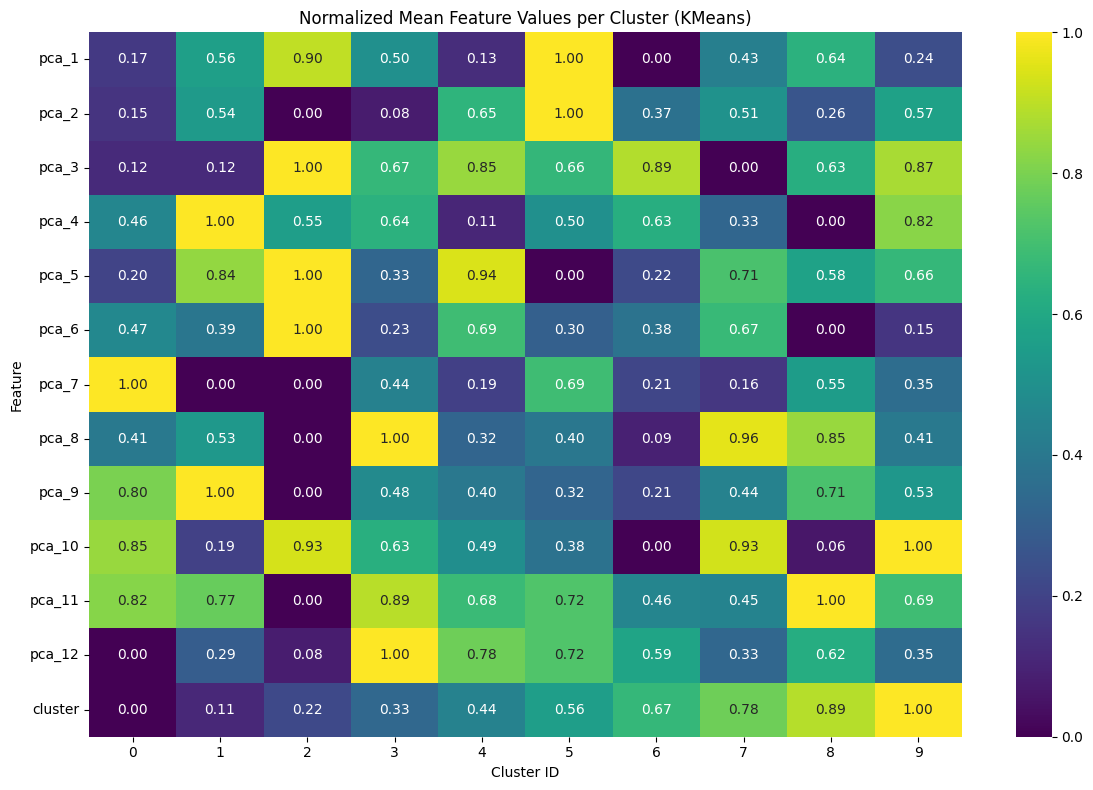

In [68]:
# Visualization of profiles
# Using mean values for demonstration
profile_plot_data = numerical_cluster_profiles.xs('mean', axis=1, level=1) # Get mean values

# It's often better to plot the scaled values if ranges are very different,
# or normalize the means for plotting on the same scale
profile_plot_data_normalized = (profile_plot_data - profile_plot_data.min()) / \
                               (profile_plot_data.max() - profile_plot_data.min())


plt.figure(figsize=(12, max(6, optimal_k * 0.8) )) # Adjust size based on K
sns.heatmap(profile_plot_data_normalized.T, annot=True, cmap="viridis", fmt=".2f")
plt.title(f'Normalized Mean Feature Values per Cluster ({algorithm_name})')
plt.xlabel('Cluster ID')
plt.ylabel('Feature')
plt.xticks(ticks=np.arange(optimal_k) + 0.5, labels=np.arange(optimal_k))
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


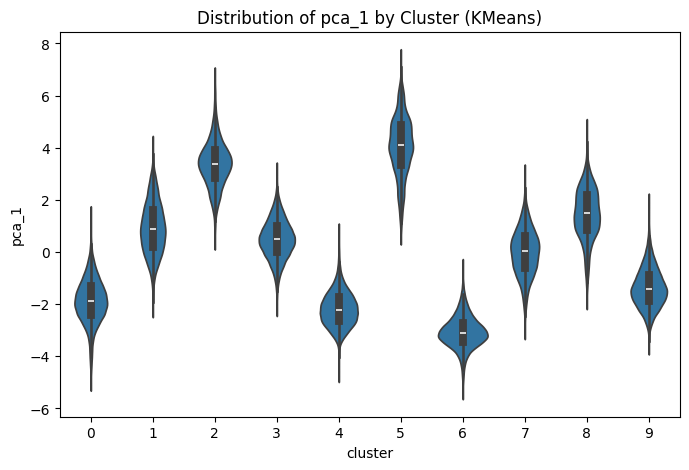

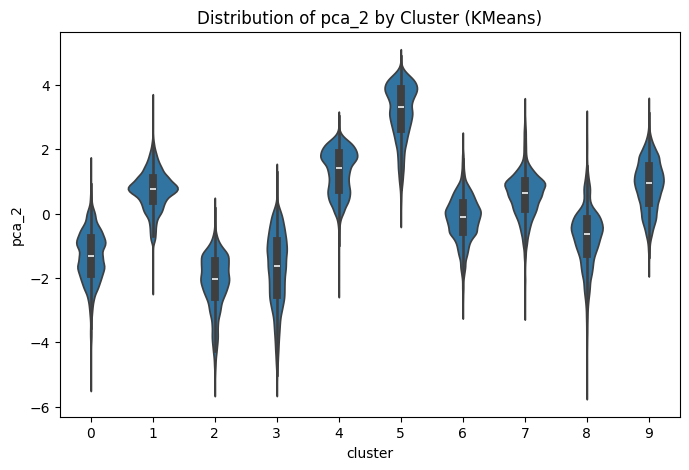

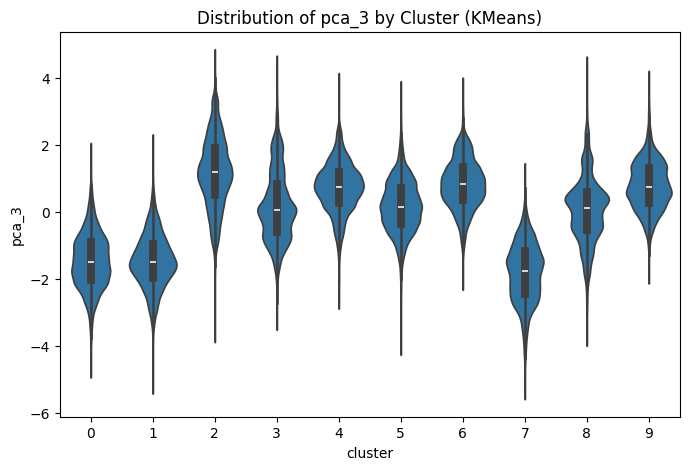

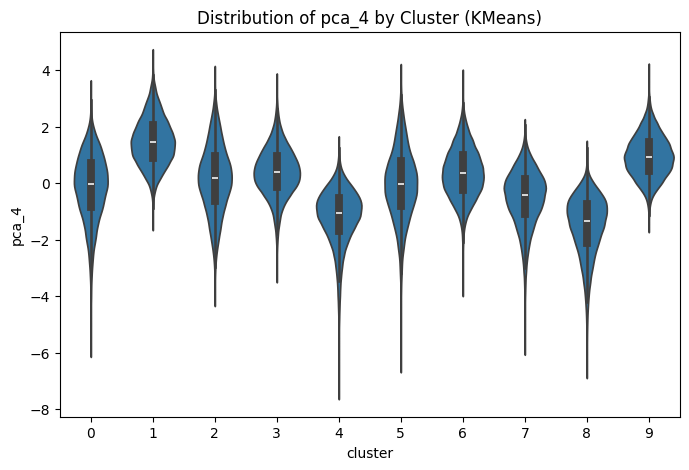

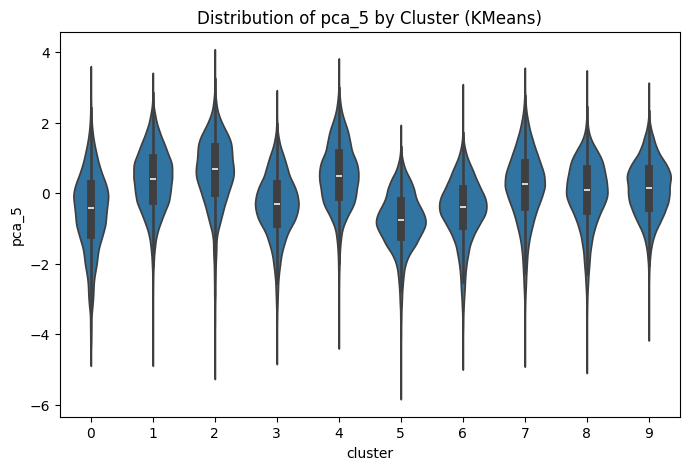

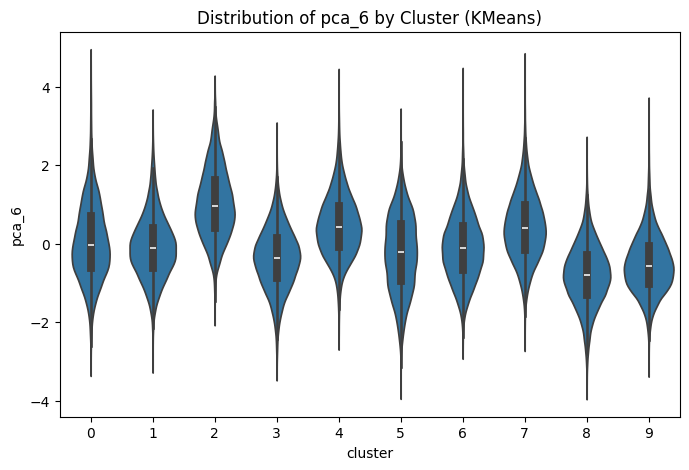

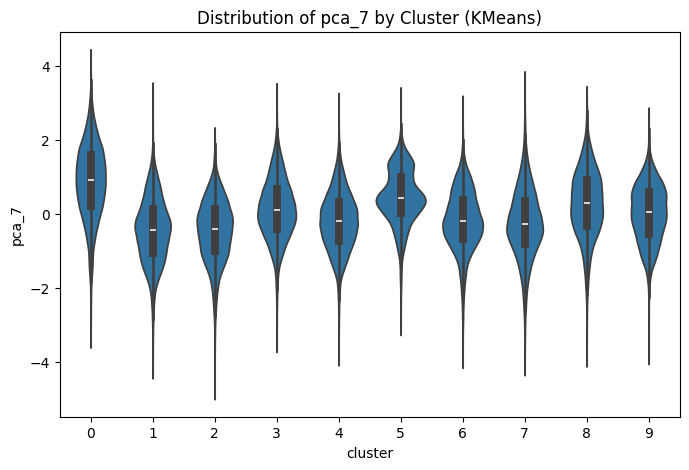

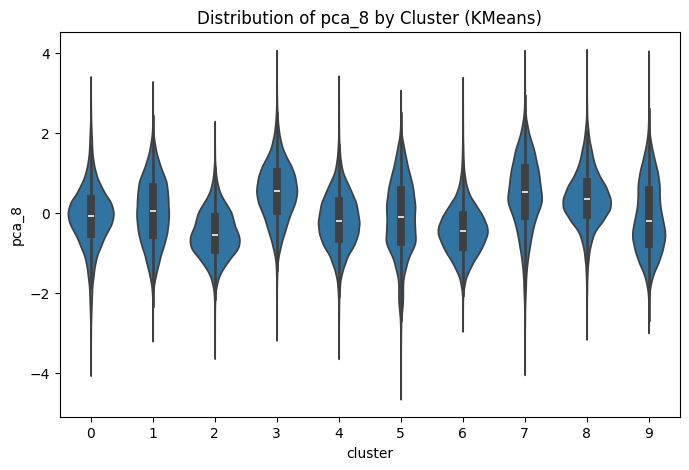

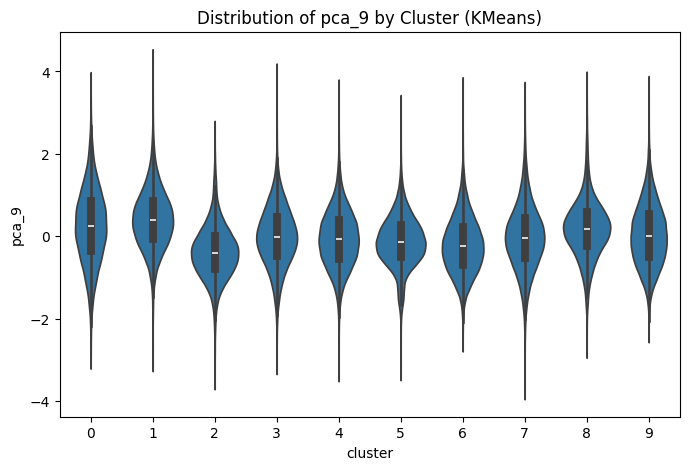

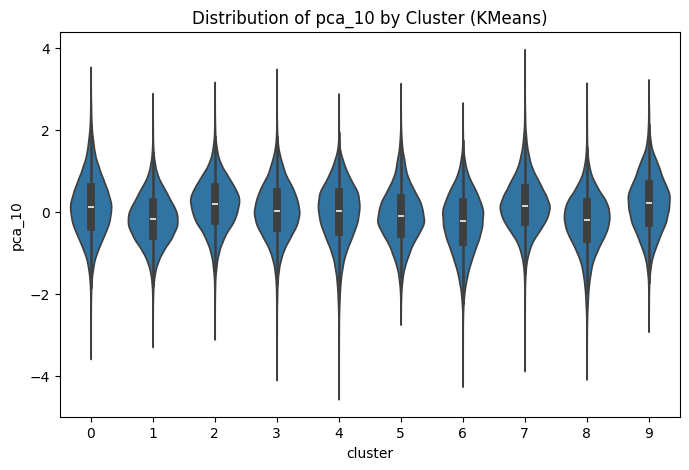

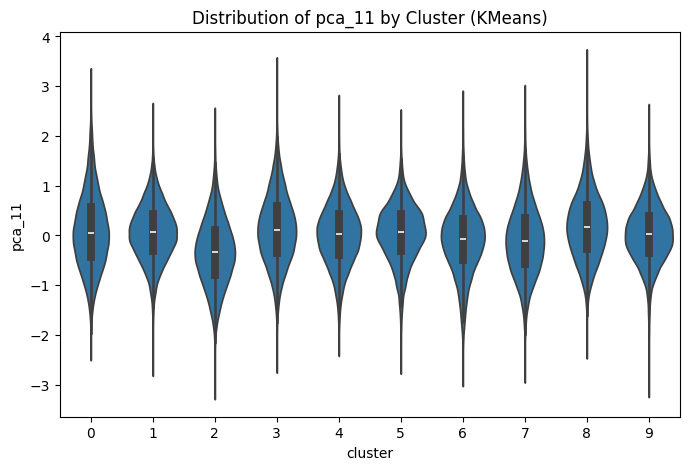

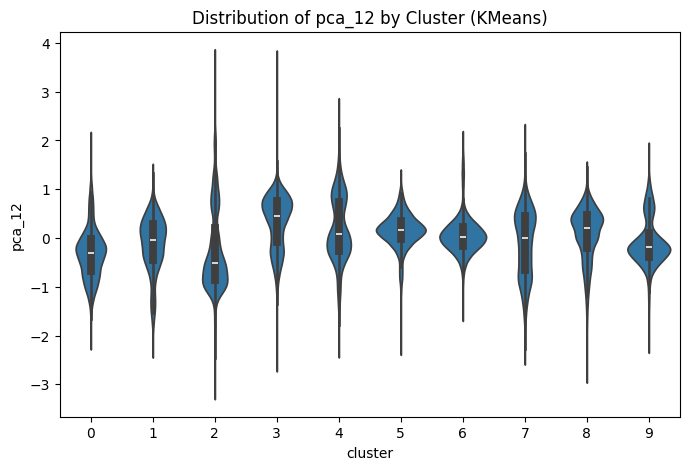

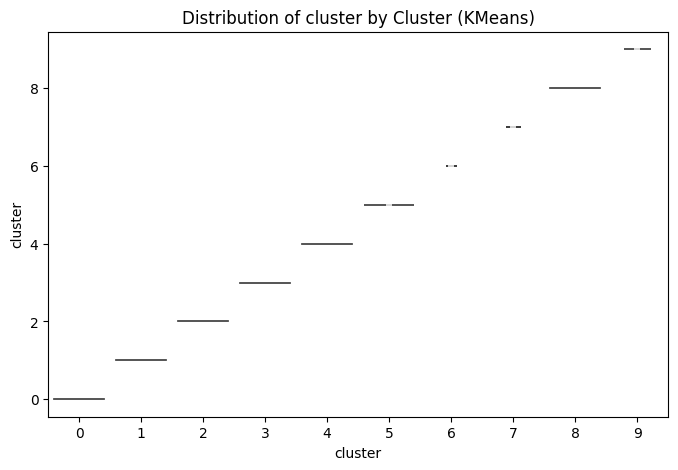

In [69]:

# Box plots for each feature by cluster
for feature in pca_feats:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='cluster', y=feature, data=df_with_clusters)
    plt.title(f'Distribution of {feature} by Cluster ({algorithm_name})')
    plt.show()